# Fraud detection in crypto transaction networks, using Graph Attention Network.

## Prerequisites
- Being familiar with **ML** and **Deep Learning**
- Understanding of **Attention mechanism**
- Basic knowledge of **PyTorch**

## Introduction
*Note: this tutorial code is based on **Graph Neural Networks for Fraud Detection in Crypto Transactions** ([Zorkaltseva (2022)](https://mariazork.github.io/machine%20learning/deep%20learning/2022/09/01/graph-neural-networks-for-fraud-detection-in-crypto-transactions.html)).
Also, some parts of tutorial could be adapted from **Evolve GAT — A dynamic graph attention model** ([Eliassen (2023)](https://medium.com/stanford-cs224w/evolve-gat-a-dynamic-graph-attention-model-d3a416bb7c33)) and **Stanford CS224W Colab** ([link](https://github.com/luciusssss/CS224W-Colab/blob/main/CS224W-Colab%203.ipynb)).*

Despite significant progress within deep learning areas such as computer vision, natural language/audio processing, time series forecasting, etc., the majority of problems work with non-euclidian geometric data and as an example of such data are social network connections, IoT sensors topology, molecules, gene expression data and so on. The non-Euclidian nature of data implies that all properties of Euclidian vector space $R^n$ can not be applied to such data samples; for example, [shift-invariance](https://stats.stackexchange.com/questions/121703/what-does-shift-invariant-mean-in-convolutional-neural-network#:~:text=Shift-invariance%3A%20this%20means%20that%20if,shifted%20by%20the%20same%20amount), which is an important property for Convolutional Neural Networks (CNN), does not save her.

In this tutorial, we will consider the semi-supervised node classification problems using Graph Attention Network and evaluate its performance on the Elliptic dataset, which contains crypto transaction data.

## Attention-based spatial Convolutional GNN
Among spatial-based convolutional GNN models, the following models are widely known: GAT, GraphSage, MoNet, GAAN, DiffPool, and others. The working principle is similar to CNN convolution operator application to image data, except the spatial approach applies convolution to differently sized node neighbors of a graph.

Attention mechanism gained wide popularity thanks to the models used in NLP tasks (e.g., LSTM with attention, transformers). In the case of GNN having an attention mechanism, contributions of neighboring nodes to the considered node are neither identical nor pre-defined, as, for example, in [GraphSage](https://arxiv.org/pdf/1706.02216.pdf) or [GCN](https://computationalsocialnetworks.springeropen.com/articles/10.1186/s40649-019-0069-y?ref=https://githubhelp.com) models.

In this tutorial we will use [GAT](https://arxiv.org/pdf/1710.10903v3.pdf) model, which leverages masked self-attentional layers.


## Graph Attention Network (GAT)
### GNN architecture
To introduce the graph ML approach to predictions over static networks, we'll briefly describe the reader how Graph Convolutional Networks (GCNs) and Graph Attention Networks (GATs) work. As Graph Neural Network (GNN) architectures, both of these network types are able to better leverage connections between nodes compared to standard Fully Connected Neural Networks (FCNNs). GCNs specifically use neighborhood aggregation as a “convolution” operation, akin to the convolutional filter in a standard CNN, but over each node’s *set of neighbors*.

![CNN and GCN](figures/cnn_and_gcn.gif)

GAT, a more expressive class, instead learns attention weights that help scale these convolution weights. Recall that these weights refer to the importance of a neighbor node $j$'s features on those of node $i$ that we are operating upon. For a GCN, these coefficients are simply predetermined from the graph structure and these coefficients are equal as long as there exists an edge between node $i$ and $j$. For a GAT, through an attention mechanism inputting the relevant node embeddings of each edge, relevant edges may be weighted higher.

### GAT architecture
The building block of the Graph Attention Network is the graph attention layer, which is a variant of the aggregation function. Let $N$ be the number of nodes and $F$ be the dimension of the feature vector for each node. The input to each graph attentional layer is a set of node features: $\mathbf{h} = \{\overrightarrow{h_1}, \overrightarrow{h_2}, \dots, \overrightarrow{h_N}$\}, $\overrightarrow{h_i} \in R^F$. The output of each graph attentional layer is a new set of node features, which may have a new dimension $F'$: $\mathbf{h'} = \{\overrightarrow{h_1'}, \overrightarrow{h_2'}, \dots, \overrightarrow{h_N'}\}$, with $\overrightarrow{h_i'} \in \mathbb{R}^{F'}$.

We will now describe how this transformation is performed for each graph attention layer. First, a shared linear transformation parametrized by the weight matrix $\mathbf{W} \in \mathbb{R}^{F' \times F}$ is applied to every node.

Next, we perform self-attention on the nodes. We use a shared attention function $a$:
\begin{equation}
a : \mathbb{R}^{F'} \times \mathbb{R}^{F'} \rightarrow \mathbb{R}.
\end{equation}

that computes the attention coefficients capturing the importance of node $j$'s features to node $i$:
\begin{equation}
e_{ij} = a(\mathbf{W_l}\overrightarrow{h_i}, \mathbf{W_r} \overrightarrow{h_j})
\end{equation}

The most general formulation of self-attention allows every node to attend to all other nodes which drops all structural information. However, to utilize graph structure in the attention mechanisms, we use **masked attention**. In masked attention, we only compute attention coefficients $e_{ij}$ for nodes $j \in \mathcal{N}_i$ where $\mathcal{N}_i$ is some neighborhood of node $i$ in the graph.

To easily compare coefficients across different nodes, we normalize the coefficients across $j$ using a softmax function:
\begin{equation}
\alpha_{ij} = \text{softmax}_j(e_{ij}) = \frac{\exp(e_{ij})}{\sum_{k \in \mathcal{N}_i} \exp(e_{ik})}
\end{equation}

For this problem, our attention mechanism $a$ will be a single-layer feedforward neural network parametrized by a weight vectors $\overrightarrow{a_l} \in \mathbb{R}^{F'}$ and $\overrightarrow{a_r} \in \mathbb{R}^{F'}$, followed by a LeakyReLU nonlinearity (with negative input slope 0.2). Let $\cdot^T$ represent transposition and $||$ represent concatenation. The coefficients computed by our attention mechanism may be expressed as:

\begin{equation}
\alpha_{ij} = \frac{\exp\Big(\text{LeakyReLU}\Big(\overrightarrow{a_l}^T \mathbf{W_l} \overrightarrow{h_i} + \overrightarrow{a_r}^T\mathbf{W_r}\overrightarrow{h_j}\Big)\Big)}{\sum_{k\in \mathcal{N}_i} \exp\Big(\text{LeakyReLU}\Big(\overrightarrow{a_l}^T \mathbf{W_l} \overrightarrow{h_i} + \overrightarrow{a_r}^T\mathbf{W_r}\overrightarrow{h_k}\Big)\Big)}
\end{equation}


At every layer of GAT, after the attention coefficients are computed for that layer, the aggregation function can be computed by a weighted sum of neighborhood messages, where weights are specified by $\alpha_{ij}$.

Now, we use the normalized attention coefficients to compute a linear combination of the features corresponding to them. These aggregated features will serve as the final output features for every node.

\begin{equation}
h_i' = \sum_{j \in \mathcal{N}_i} \alpha_{ij} \mathbf{W_r} \overrightarrow{h_j}
\end{equation}

### Multiple attention mechanisms in GAT
To improve the stability of the learning process, Multi-head attention is employed. Specifically, $K$ independent attention mechanisms execute the transformation of previous Equation, and then their features are
concatenated, resulting in the following output feature representation:

\begin{equation}
\DeclareMathOperator*{\bigparallel}{\parallel}
h_i' = \bigparallel_{k=1}^{K}
\left(
\sum_{j \in \mathcal{N}_i} \alpha_{ij}^k \mathbf{W_r^k} \overrightarrow{h_j}
\right)
\end{equation}

where $\parallel$ represents concatenation.
Note that, in this setting, the final returned output, $h'$, will consist of $KF'$ features (rather than $F'$) for each node.

Specially, if we perform multi-head attention on the final (prediction) layer of the network, concatenation is no longer sensible—instead, we employ *averaging*:

\begin{equation}
h_i' = \frac{1}{K} \sum_{k=1}^{K} \sum_{j \in \mathcal{N}_i} \alpha_{ij}^k \mathbf{W_r^k} \overrightarrow{h_j}
\end{equation}

The aggregation process of a multi-head graph attentional layer is illustrated by Figure 1 (right).

<figure>
  <img
  src="figures/attention_mechanism.png"
  alt="Attention layer"
  width=1080>
  <figcaption>
  Figure 1: <b>Left</b>: The attention mechanism $a(\mathbf{W_l}\overrightarrow{h_i}, \mathbf{W_r} \overrightarrow{h_j})$ employed by model, parametrized by a weight vector $\vec{\textbf{a}} \in \mathbb{R}^{2F'}$, applying a LeakyReLU activation. <b>Right</b>: An illustration of multihead attention (with $K = 3$ heads) by node 1 on its neighborhood. Different arrow styles and colors denote independent attention computations. The aggregated features from each head are concatenated or averaged to obtain $\vec{h'_1}$.
  </figcaption>
</figure>

## Install dependencies

With all the theory done, let's proceed to the implementation part.
We will implement our GAT model, using [PyTorch Geometric](https://pytorch-geometric.readthedocs.io/en/latest/index.html).

In [1]:
%%capture
!pip install torch-scatter -f https://data.pyg.org/whl/torch-2.1.0+cu118.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-2.1.0+cu118.html
!pip install torch-geometric

## Imports
Import all the modules, we will need later.

In [2]:
import os
import copy
import torch
import warnings
import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from torch_geometric.utils import to_networkx
from torch_geometric.data import Data, DataLoader

import torch.nn.functional as F
from torch.nn import Linear, BatchNorm1d
from torch_geometric.nn import GATv2Conv

from types import SimpleNamespace

warnings.filterwarnings('ignore')

## Dataset
Here, for the node classification task, we will use the [Elliptic dataset](https://www.kaggle.com/datasets/ellipticco/elliptic-data-set). Dataset consists of **203 769 nodes** and **234 355 edges**. Dataset represents bitcoin blockchain as a graph. Nodes are represented as **transactions** and edges are represented as a **bitcoin flow** between transactions. There are 3 node classes: *“licit”, “illicit”, or “unknown”*, where the majority of the nodes is unknown. The task is to classify nodes as *“licit”* or *“illicit”*.

Each node has **166 features**, where first **94 features** represent local information and the remaining **72 features** are aggregated features. More detailed feature description is unavailable for security reasons.

Here is the visualization of Address-Transaction graph:
![Address-Transaction graph](figures/dataset.jpg)

Let's load Elliptic dataset from [`torch_geometric.datasets`](https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html). This saves the dataset to the `root` directory.

In [3]:
from torch_geometric.datasets import EllipticBitcoinDataset
dataset = EllipticBitcoinDataset(root='./data/elliptic-bitcoin-dataset')

Let's now have a look at the data.

In [4]:
df_features = pd.read_csv('./data/elliptic-bitcoin-dataset/raw/elliptic_txs_features.csv', header=None)
df_edges = pd.read_csv("./data/elliptic-bitcoin-dataset/raw/elliptic_txs_edgelist.csv")
df_classes =  pd.read_csv("./data/elliptic-bitcoin-dataset/raw/elliptic_txs_classes.csv")
df_classes['class'] = df_classes['class'].map({'unknown': 2, '1': 1, '2': 0})

`df_features` contains each node id and corresponding features.

In [5]:
# nodes features
df_features.head()

,0,1,2,3,4,5,6,7,8,9,...,157,158,159,160,161,162,163,164,165,166
0,230425980,1,-0.171469,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162097,...,-0.562153,-0.600999,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
1,5530458,1,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162112,...,0.947382,0.673103,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
2,232022460,1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162749,...,0.670883,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792
3,232438397,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,-0.163645,...,-0.577099,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792
4,230460314,1,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,-0.163523,...,-0.511871,-0.400422,0.517257,0.579382,0.018279,0.277775,0.326394,1.293750,0.178136,0.179117


`df_edges` contains list of edges.

In [6]:
# edges
df_edges.head()

,txId1,txId2
0,230425980,5530458
1,232022460,232438397
2,230460314,230459870
3,230333930,230595899
4,232013274,232029206


`df_classes` contains each node id and corresponding class, where *0 - licit, 1 - ilicit* and *2 - unknown*.

In [7]:
# classes
# 0 — legitimate
# 1 — fraud
# 2 — unknown class
df_classes.head()

,txId,class
0,230425980,2
1,5530458,2
2,232022460,2
3,232438397,0
4,230460314,2


Here is the class distribution.

In [8]:
df_classes['class'].value_counts()

2    157205
0     42019
1      4545
Name: class, dtype: int64

## Preprocessing
Now, let's convert our data into the `torch_geometric.data.Data` object. First, let's make a dataframe that contains both node features and class.

In [9]:
# merging node features DF with classes DF
df_merge = df_features.merge(df_classes, how='left', right_on="txId", left_on=0)
df_merge = df_merge.sort_values(0).reset_index(drop=True)

Next, we will need edges in a [COO format](https://en.wikipedia.org/wiki/Sparse_matrix#Coordinate_list_(COO)). To do that, we map `edges.txId1` and `edges.txId2` to the indices of the corresponding nodes in a `df_merge`. In the end we store edge indices as `torch.Tensor`.

In [10]:
# mapping nodes to indices
nodes = df_merge[0].values
map_id = {j:i for i,j in enumerate(nodes)}

# mapping edges to indices
edges = df_edges.copy()
edges.txId1 = edges.txId1.map(map_id)
edges.txId2 = edges.txId2.map(map_id)
edges = edges.astype(int)

edge_index = np.array(edges.values).T
edge_index = torch.tensor(edge_index, dtype=torch.long).contiguous()

# weights for the edges are equal in case of model without attention
weights = torch.tensor([1] * edge_index.shape[1] , dtype=torch.float32)

print("Total amount of edges in DAG:", edge_index.shape)

Total amount of edges in DAG: torch.Size([2, 234355])


Next, we will need node feature matrix. Here we also map each ID to corresponding index. Then, we will store all the unknown nodes in `unclassified_idx`, that's why we remove class 2, since we no longer need it. In the end, we drop everything but features and store it as `torch.Tensor`.

In [11]:
# maping node ids to corresponding indexes
node_features = df_merge.drop(['txId'], axis=1).copy()
node_features[0] = node_features[0].map(map_id)

# store known and unknown nodes
classified_idx = node_features['class'].loc[node_features['class'] != 2].index
unclassified_idx = node_features['class'].loc[node_features['class'] == 2].index

# replace unkown class with 0, to avoid having 3 classes, this data/labels never used in training
node_features['class'] = node_features['class'].replace(2, 0)

labels = node_features['class'].values

# drop indeces, class and temporal axes
node_features = torch.tensor(np.array(node_features.drop([0, 'class', 1], axis=1).values, dtype=np.float32), dtype=torch.float32)

In this cell, we finally create an object of type `torch_geometric.data.Data`. Here, we pass following parameters:
- `x` – Node feature matrix with shape.

- `edge_index` – Graph connectivity in COO format with shape `[2, num_edges]`.

- `edge_attr` – Edge feature matrix with shape `[num_edges, num_edge_features]`.

- `y` – Graph-level or node-level ground-truth labels with arbitrary shape.

We also print a brief description of our network.

In [12]:
# converting data to PyGeometric graph data format
elliptic_dataset = Data(x = node_features,
                        edge_index = edge_index,
                        edge_attr = weights,
                        y = torch.tensor(labels, dtype=torch.float32))

print(f'Number of nodes: {elliptic_dataset.num_nodes}')
print(f'Number of node features: {elliptic_dataset.num_features}')
print(f'Number of edges: {elliptic_dataset.num_edges}')
print(f'Number of edge features: {elliptic_dataset.num_features}')
print(f'Average node degree: {elliptic_dataset.num_edges / elliptic_dataset.num_nodes:.2f}')
print(f'Number of classes: {len(np.unique(elliptic_dataset.y))}')
print(f'Has isolated nodes: {elliptic_dataset.has_isolated_nodes()}')
print(f'Has self loops: {elliptic_dataset.has_self_loops()}')
print(f'Is directed: {elliptic_dataset.is_directed()}')

Number of nodes: 203769
Number of node features: 165
Number of edges: 234355
Number of edge features: 165
Average node degree: 1.15
Number of classes: 2
Has isolated nodes: False
Has self loops: False
Is directed: True


Here, we create a config to keep all parameters in one place.

In [13]:
config = SimpleNamespace(seed = 0,
                         learning_rate = 0.001,
                         weight_decay = 1e-5,
                         input_dim = 165,
                         output_dim = 1,
                         hidden_size = 128,
                         num_epochs = 400,
                         checkpoints_dir = './models/elliptic_gnn',
                         device = torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

print("Using device:", config.device)

Using device: cuda


Finally, we split our data into train, valid and test; where train and valid are 0.85 and 0.15 partitions of the classified nodes and test is all unclassified nodes.

In [14]:
y_train = labels[classified_idx]

# spliting train set and validation set
_, _, _, _, train_idx, valid_idx = train_test_split(node_features[classified_idx],
                                                    y_train,
                                                    classified_idx,
                                                    test_size=0.15,
                                                    random_state=config.seed,
                                                    stratify=y_train)

elliptic_dataset.train_idx = torch.tensor(train_idx, dtype=torch.long)
elliptic_dataset.val_idx = torch.tensor(valid_idx, dtype=torch.long)
elliptic_dataset.test_idx = torch.tensor(unclassified_idx, dtype=torch.long)

print("Train dataset size:", elliptic_dataset.train_idx.shape[0])
print("Validation dataset size:", elliptic_dataset.val_idx.shape[0])
print("Test dataset size:", elliptic_dataset.test_idx.shape[0])

Train dataset size: 39579
Validation dataset size: 6985
Test dataset size: 157205


## Model and metric definition
Here, we will use 2 layers of graph attention: `self.gat1` and `self.gat2`, which are initialized with `torch_geometric.nn.GATv2Conv` class. Both attention layers use multi-headed attention, but on the output layer we use averaging, insted of concatenation, as proposed in theory part. We also apply **dropout** and **batch normalization** on each layer to improve stability.

We also define **accuracy** metric here.

In [15]:
class GAT(torch.nn.Module):
    """Graph Attention Network"""
    def __init__(self, dim_in, dim_h, dim_out, heads=8):
        super(GAT, self).__init__()
        self.norm1 = BatchNorm1d(dim_in)
        self.gat1 = GATv2Conv(dim_in, dim_h, heads=heads,
                              dropout=0.3)
        self.norm2 = BatchNorm1d(dim_h*heads)
        self.gat2 = GATv2Conv(dim_h*heads, dim_out, heads=heads,
                              concat=False, dropout=0.6)

    def forward(self, x, edge_index):
        h = self.norm1(x)
        h = self.gat1(h, edge_index)
        h = self.norm2(h)
        h = F.leaky_relu(h)
        out = self.gat2(h, edge_index)
        return out

def accuracy(y_pred, y_test, prediction_threshold=0.5):
    y_pred_label = (torch.sigmoid(y_pred) > prediction_threshold).float()

    correct_results_sum = (y_pred_label == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]

    return acc

## Training
Here we do simple training and testing for binary classification just like in pure **PyTorch**.

*See [PyTorch Tutorials](https://pytorch.org/tutorials/beginner/introyt/trainingyt.html) for reference.*

In [29]:
def train_evaluate(model, data, criterion, optimizer, *args):
    num_epochs = args[0]
    checkpoints_dir = args[1]
    model_filename = args[2]

    best_model_wts = copy.deepcopy(model.state_dict())

    best_loss = float('inf')

    if not os.path.exists(checkpoints_dir):
        os.makedirs(checkpoints_dir)

    model.train()
    for epoch in range(num_epochs+1):
        # Training
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        loss = criterion(out[data.train_idx], data.y[data.train_idx].unsqueeze(1))
        acc = accuracy(out[data.train_idx], data.y[data.train_idx].unsqueeze(1), prediction_threshold=0.5)
        loss.backward()
        optimizer.step()

        # Validation
        val_loss = criterion(out[data.val_idx], data.y[data.val_idx].unsqueeze(1))
        val_acc = accuracy(out[data.val_idx], data.y[data.val_idx].unsqueeze(1), prediction_threshold=0.5)

        if epoch % 10 == 0:
            print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc: '
                  f'{acc*100:>6.2f}% | Val Loss: {val_loss:.4f} | '
                  f'Val Acc: {val_acc*100:.2f}%')

            if val_loss < best_loss:
                best_loss = val_loss
                print("Saving model for best loss")
                checkpoint = {'state_dict': best_model_wts}
                torch.save(checkpoint, os.path.join(checkpoints_dir, model_filename))
                best_model_wts = copy.deepcopy(model.state_dict())

    return model

def test(model, data):
    model.eval()
    out = model(data.x, data.edge_index)
    preds = ((torch.sigmoid(out) > 0.5).float()*1).squeeze(1)
    return preds

In [17]:
torch.manual_seed(config.seed)

gat_model = GAT(config.input_dim, config.hidden_size, config.output_dim).to(config.device)
data_train = elliptic_dataset.to(config.device)

optimizer = torch.optim.Adam(gat_model.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay)
criterion = torch.nn.BCEWithLogitsLoss()

train_evaluate(gat_model,
               data_train,
               criterion,
               optimizer,
               config.num_epochs,
               config.checkpoints_dir,
               'gat_best_model.pth.tar')

Epoch   0 | Train Loss: 0.761 | Train Acc:  49.94% | Val Loss: 0.7537 | Val Acc: 51.14%
Saving model for best loss
Epoch  10 | Train Loss: 0.246 | Train Acc:  90.47% | Val Loss: 0.2445 | Val Acc: 90.44%
Saving model for best loss
Epoch  20 | Train Loss: 0.221 | Train Acc:  91.39% | Val Loss: 0.2199 | Val Acc: 91.54%
Saving model for best loss
Epoch  30 | Train Loss: 0.201 | Train Acc:  92.76% | Val Loss: 0.1979 | Val Acc: 92.71%
Saving model for best loss
Epoch  40 | Train Loss: 0.186 | Train Acc:  93.70% | Val Loss: 0.1857 | Val Acc: 93.47%
Saving model for best loss
Epoch  50 | Train Loss: 0.172 | Train Acc:  94.33% | Val Loss: 0.1765 | Val Acc: 94.14%
Saving model for best loss
Epoch  60 | Train Loss: 0.163 | Train Acc:  94.82% | Val Loss: 0.1652 | Val Acc: 94.70%
Saving model for best loss
Epoch  70 | Train Loss: 0.153 | Train Acc:  95.26% | Val Loss: 0.1564 | Val Acc: 95.18%
Saving model for best loss
Epoch  80 | Train Loss: 0.147 | Train Acc:  95.67% | Val Loss: 0.1492 | Val Acc:

GAT(
  (norm1): BatchNorm1d(165, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gat1): GATv2Conv(165, 128, heads=8)
  (norm2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gat2): GATv2Conv(1024, 1, heads=8)
)

## Evaluating
Finally, we can evaluate our model. Our main target is to detect fraudsters, which means that we are mostly interested in **illicit F1 score = 0.89**, which is pretty could for our task.

Also, confusion matrix and full classification report are provided here.

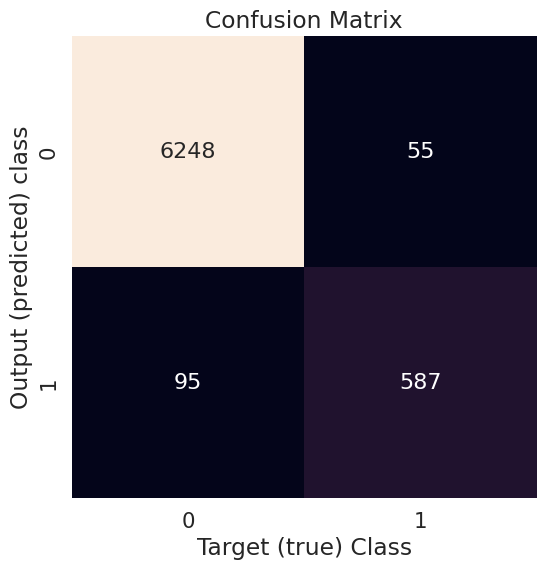

              precision    recall  f1-score   support

       licit       0.99      0.99      0.99      6303
     illicit       0.91      0.86      0.89       682

    accuracy                           0.98      6985
   macro avg       0.95      0.93      0.94      6985
weighted avg       0.98      0.98      0.98      6985



In [30]:
gat_model.load_state_dict(torch.load(os.path.join(config.checkpoints_dir, 'gat_best_model.pth.tar'))['state_dict'])

y_test_preds = test(gat_model, data_train)

# confusion matrix on validation data
conf_mat = confusion_matrix(data_train.y[data_train.val_idx].detach().cpu().numpy(), y_test_preds[valid_idx].cpu())

plt.subplots(figsize=(6,6))
sns.set(font_scale=1.4)
sns.heatmap(conf_mat, annot=True, fmt=".0f", annot_kws={"size": 16}, cbar=False)
plt.xlabel('Target (true) Class'); plt.ylabel('Output (predicted) class'); plt.title('Confusion Matrix')
plt.show();

print(classification_report(data_train.y[data_train.val_idx].detach().cpu().numpy(),
                            y_test_preds[valid_idx].cpu(),
                            target_names=['licit', 'illicit']))